# Loans

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
# Download the dataset
loans = pd.read_csv("https://myslu.stlawu.edu/~ltorrey/ml/Loans.csv")

In [4]:
# Inspect the first few rows
loans.head()

,gender,age,request,duration,purpose,job_type,housing,savings,checking,approved
0,male,67,1169,6,radio/TV,2,own,not_known,little,1
1,female,22,5951,48,radio/TV,2,own,little,moderate,0
2,male,49,2096,12,education,1,own,little,not_known,1
3,male,45,7882,42,furniture/equipment,2,free,little,little,1
4,male,53,4870,24,car,2,free,little,little,0


In [5]:
loans["gender"].value_counts()

male      690
female    310
Name: gender, dtype: int64

In [6]:
loans["approved"].value_counts()

1    700
0    300
Name: approved, dtype: int64

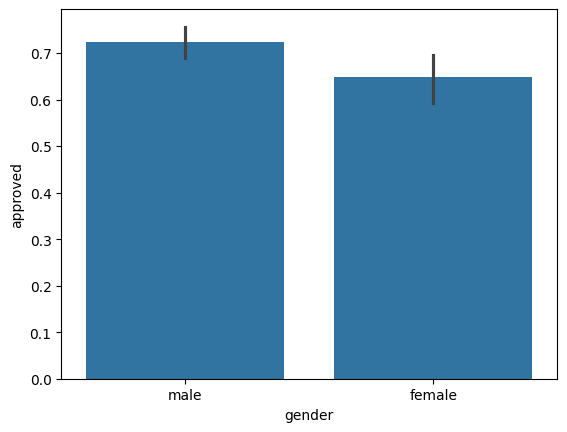

In [7]:
plot = sns.barplot(data=loans,x="gender", y = "approved")

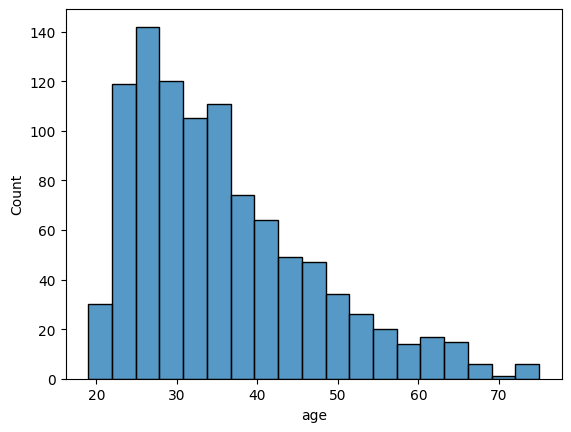

In [8]:
plot = sns.histplot(data=loans, x = "age")

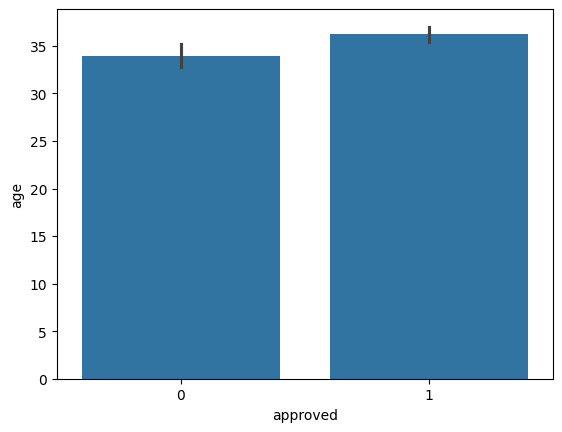

In [9]:
# avg age of applicants who were or werent approved
plot = sns.barplot(data=loans,x="approved", y = "age")

# Classifiers



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [11]:
# Separate features and target
x = loans.drop("approved", axis=1)
y = loans["approved"]

In [12]:
# Split the data in half
xtrain, xtest, ytrain, ytest = train_test_split(x, y, stratify=y, test_size=0.5)

In [13]:
# Arrange data processing
transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), ["purpose", "housing", "savings", "checking"]),
    (StandardScaler(), ["request", "duration", "job_type"]),
    remainder="drop"
)

In [14]:
# Fit some classifiers
knn = make_pipeline(transformer, KNeighborsClassifier()).fit(xtrain, ytrain)
svm = make_pipeline(transformer, LinearSVC()).fit(xtrain, ytrain)
forest = make_pipeline(transformer, RandomForestClassifier()).fit(xtrain, ytrain)

# Performance

In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [16]:
# Compare accuracy scores
print("knn accuracy", knn.score(xtest, ytest))
print("svm accuracy", svm.score(xtest, ytest))
print("forest accuracy", forest.score(xtest, ytest))

knn accuracy 0.694
svm accuracy 0.742
forest accuracy 0.716


In [17]:
# Compare precision scores
print("knn precision", precision_score(ytest, knn.predict(xtest)))
print("svm precision", precision_score(ytest, svm.predict(xtest)))
print("forest precision", precision_score(ytest, knn.predict(xtest)))

knn precision 0.7532133676092545
svm precision 0.7612293144208038
forest precision 0.7532133676092545


In [18]:
# Compare recall scores
print("knn recall", recall_score(ytest, knn.predict(xtest)))
print("svm recall", recall_score(ytest, svm.predict(xtest)))
print("forest recall", recall_score(ytest, knn.predict(xtest)))

knn recall 0.8371428571428572
svm recall 0.92
forest recall 0.8371428571428572


# Curves

In [27]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

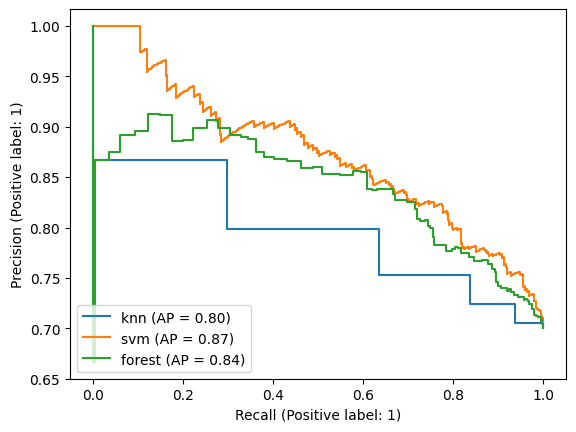

In [28]:
# Compare precision-recall curves
figure, axes = plt.subplots()
PrecisionRecallDisplay.from_estimator(knn, xtest, ytest, name="knn", ax=axes)
PrecisionRecallDisplay.from_estimator(svm, xtest, ytest, name="svm", ax=axes)
PrecisionRecallDisplay.from_estimator(forest, xtest, ytest, name="forest", ax=axes)
plt.show()

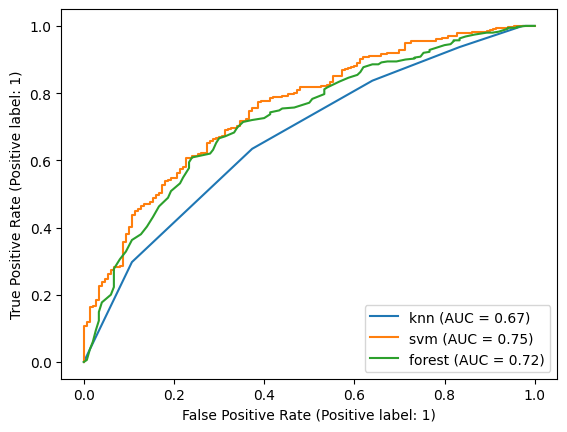

In [29]:
# Compare ROC curves
figure, axes = plt.subplots()
RocCurveDisplay.from_estimator(knn, xtest, ytest, name="knn", ax=axes)
RocCurveDisplay.from_estimator(svm, xtest, ytest, name="svm", ax=axes)
RocCurveDisplay.from_estimator(forest, xtest, ytest, name="forest", ax=axes)
plt.show()

# Fairness

In [30]:
!pip install dalex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.0-py3-none-any.whl size=1042471 sha256=c685c48227fd40fb6ed65f106ba6ea5c6e1561db283ebb9e0553f25cbf42f964
  Stored in directory: /root/.cache/pip/wheels/e2/38/c1/25a95206a4873a287d776fc8e77aa7d93971acc643ecb3db38
Successfully built dalex


In [31]:
import dalex as dx

In [32]:
# Create an explainer for each classifier
knn_explainer = dx.Explainer(knn, xtest, ytest, verbose=False)
svm_explainer = dx.Explainer(svm, xtest, ytest, verbose=False)
forest_explainer = dx.Explainer(forest, xtest, ytest, verbose=False)

In [33]:
# Compute fairness scores for each classifier
knn_fairness = knn_explainer.model_fairness(protected=xtest["gender"], privileged="male")
svm_fairness = svm_explainer.model_fairness(protected=xtest["gender"], privileged="male")
forest_fairness = forest_explainer.model_fairness(protected=xtest["gender"], privileged="male")

In [34]:
# Plot the scores
knn_fairness.plot(objects=[svm_fairness, forest_fairness], type="metric_scores")

In [35]:
# Plot the score ratios
knn_fairness.plot(objects=[svm_fairness, forest_fairness], type="fairness_check")